### Load modules

In [6]:
# general
#import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 
import random as rnd
import time

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from jax.tree_util import tree_map
from flax.training import train_state  # Useful dataclass to keep train state
import optax

# PyTorch
import torch
import torch.utils.data as data

# check versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

# import priors 
#from models.priors import *

# import functions to load data
from priorCVAE.models.data import *

# import VAE architecture
from priorCVAE.models.cvae import *

# import loss functions
from priorCVAE.models.losses import *

# Test dist_euclid
#x1 = jnp.array([1,2,3])
#dist_euclid(x1,x1)

# test kl_divergence
#x1 = jnp.array([1.1,2,3])
#kl = kl_divergence(x1, x1)
#kl

Pytorch version:  2.0.1
Numpyro version:  0.12.1
JAX version:      0.4.12
Flax version:     0.6.11
Optax version:    0.1.5
Pythorch version: 3.10.11


In [7]:
# test architecture using test_architecture.py

### Setup arguments

In [8]:
args = {"seed": 0,
        
        # data
        "num_samples": 10000,
        
        # architecture
        "conditional": False,   # CVAE if True, VAE otherwise
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 100,
        "num_epochs": 200,
        "vae_var": 1, 

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data


In [9]:


train_set = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=42)  
val_set   = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=43)  
test_set  = Dataset_GP1d(n_dataPoints=args["input_dim"], n_samples=args["num_samples"], seed=44)  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            #train=[True, False, False],
                                                            train=[True, True, True],
                                                            batch_size=args["batch_size"])

# these lines are VERY slow and produce MANY warnings - consider removing them
train_loader_iter = iter(train_loader)
val_loader_iter   = iter(val_loader)
test_loader_iter  = iter(test_loader)

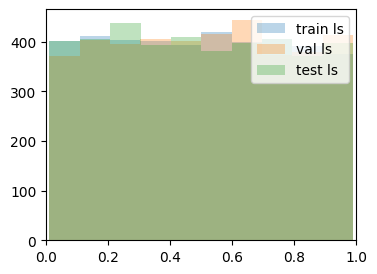

In [10]:
# check: what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set   = val_set.ls
ls_test_set  = test_set.ls

plt.figure(figsize=(4,3))
plt.hist(ls_train_set, alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set,   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set,  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()


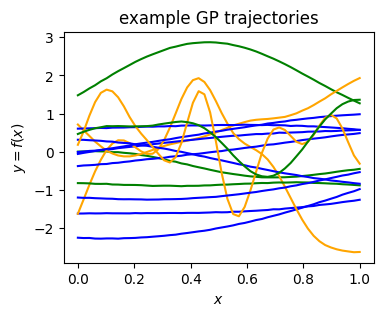

In [11]:
# check: what trajectories are we generating?

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

### VAE Model

In [15]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
conditional = args["conditional"]
batch_size  = args["batch_size"]
num_samples = args["num_samples"]
num_epochs  = args["num_epochs"]
vae_var     = args["vae_var"]

### Training loop

In [16]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        _, y, _ = batch 
        y_hat, z_mu, z_sd = model.apply({'params': params}, y) 
        rcl_loss = rcl(y_hat, y, vae_var).mean()
        kld_loss = kl_divergence(z_mu, z_sd).mean()
        loss = rcl_loss + kld_loss
        return loss
    
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads), loss_fn(state.params)

In [17]:
@jax.jit
def eval(state, batch):
    def loss_fn(params):
        _, y, _ = batch 
        y_hat, z_mu, z_sd = model.apply({'params': params}, y) 
        rcl_loss = rcl(y_hat, y, vae_var).mean()
        kld_loss = kl_divergence(z_mu, z_sd).mean()
        loss = rcl_loss + kld_loss
        return loss
    
    return loss_fn(state.params)

[    1] training loss: 2609.899, test loss: 2768.289
[   11] training loss: 720.866, test loss: 735.780
[   21] training loss: 575.279, test loss: 525.378
[   31] training loss: 418.162, test loss: 382.006
[   41] training loss: 365.422, test loss: 337.732
[   51] training loss: 241.694, test loss: 307.554
[   61] training loss: 246.977, test loss: 240.811
[   71] training loss: 274.012, test loss: 270.572
[   81] training loss: 174.491, test loss: 141.197
[   91] training loss: 241.965, test loss: 174.678
[  101] training loss: 208.015, test loss: 254.125
[  111] training loss: 172.742, test loss: 218.427
[  121] training loss: 254.995, test loss: 122.779
[  131] training loss: 131.807, test loss: 192.689
[  141] training loss: 148.697, test loss: 269.755
[  151] training loss: 238.932, test loss: 257.685
[  161] training loss: 132.047, test loss: 116.003
[  171] training loss: 209.608, test loss: 189.222
[  181] training loss: 106.977, test loss: 171.049
[  191] training loss: 232.47

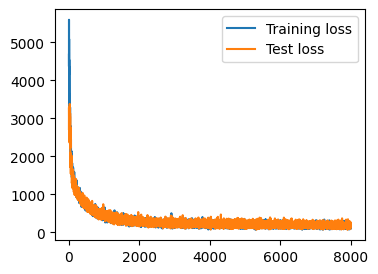

In [18]:
# define model
model = VAE(hidden_dim, latent_dim, out_dim, conditional)

# initialise parameters
key = jax.random.PRNGKey(0) 
batch_init = next(val_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, _ = batch_init
params = model.init(key, y)['params']

# optimizer
optimizer = optax.adam(learning_rate=0.001)

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

# check architecture
#print(model.tabulate(key, train_set.y,
#      console_kwargs={'force_terminal': False, 'force_jupyter': True}))

_loss_train = []
_loss_test = []

t_start = time.time()

for epoch in range(num_epochs):
    # Training phase
    for _, batch_train in enumerate(train_loader):
        state, loss_train = train_step(state, batch_train)
        _loss_train.append(loss_train)

    # Test phase
    for _, batch_test in enumerate(test_loader):
        loss_test = eval(state, batch_test)
        _loss_test.append(loss_test)

    if epoch % 10 == 0:   
        print(f'[{epoch + 1:5d}] training loss: {loss_train:.3f}, test loss: {loss_test:.3f}')

t_elapsed = time.time() - t_start

print(f'Training of {num_epochs} epochs took {round(t_elapsed)} seconds')

assert len(_loss_train) == num_epochs * num_samples // batch_size

plt.figure(figsize=(4,3))
plt.plot(range(len(_loss_train)), _loss_train, label = 'Training loss')
plt.plot(range(len(_loss_test)), _loss_test, label = 'Test loss')
plt.legend()

#### What have we learnt?

(100, 30)
(100, 50)


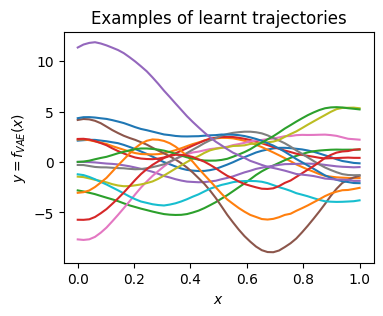

In [19]:
# Get trained decoder params
decoder_params = state.params['decoder']

rng, z_rng, init_rng = random.split(key, 3)

# latents as input
z = random.normal(z_rng, (batch_size, latent_dim))
print(z.shape)

# create decoder
decoder = Decoder(hidden_dim, out_dim)

# apply decoder with trained parameters on the data
out = decoder.apply({'params': decoder_params}, z)             
print(out.shape)

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(train_set.x[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

#### Visual diagnostics

### Inference with MCMC

#### Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

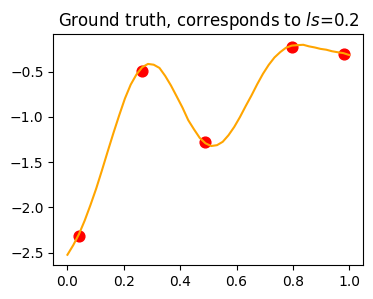

In [20]:
x = train_set[0][0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, x=x, jitter=1e-6, noise=True, length=args["true_ls"], var=1)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

In [21]:
# add data to args

args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

#### Nupmyro model

In [22]:
# import MCMC functions
from priorCVAE.models.mcmc import *

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, numpyro_model, args, decoder_params, conditional=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -2.33      0.12     -2.33     -2.51     -2.15  15252.85      1.00
      f[1]     -2.34      0.11     -2.34     -2.51     -2.15  15650.19      1.00
      f[2]     -2.31      0.11     -2.31     -2.48     -2.13  16396.75      1.00
      f[3]     -2.20      0.11     -2.21     -2.37     -2.03  16250.99      1.00
      f[4]     -2.06      0.10     -2.06     -2.22     -1.90  15912.83      1.00
      f[5]     -1.88      0.10     -1.88     -2.03     -1.73  15290.88      1.00
      f[6]     -1.64      0.10     -1.64     -1.79     -1.49  14099.21      1.00
      f[7]     -1.40      0.10     -1.40     -1.56     -1.25  13607.53      1.00
      f[8]     -1.19      0.10     -1.19     -1.35     -1.03  14204.36      1.00
      f[9]     -0.99      0.10     -0.99     -1.16     -0.83  14278.89      1.00
     f[10]     -0.80      0.11     -0.80     -0.98     -0.64  14536.62      1.00
     f[11]     -0.65      0

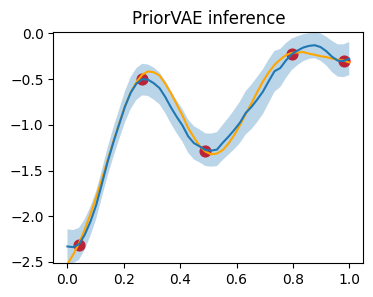

In [23]:
predictive = Predictive(numpyro_model, mcmc_vae_samples)
predictions_vae = predictive(rng_key_preds, args, decoder_params)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

if conditional:
    plt.title('PriorCVAE inference')
else:
    plt.title('PriorVAE inference')